In [1]:
%pylab inline

import os
from scipy.ndimage.filters import gaussian_filter

import styles.paper
from styles.colors import *
from styles.labels import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
path = os.path.expandvars("$phd/inputs/tta_cb13/ssag")
rpath = os.path.expandvars("$phd/inputs/tta_bc03")

colors = genfromtxt("{}/SSAG_1.00TauV.log".format(path), dtype=None, names=True, skip_header=2)
params = genfromtxt("{}/true_params.log".format(path), dtype=None, names=True)
recipe = genfromtxt("{}/SSAG_catalog.txt".format(rpath), dtype=None, names=True, missing_values='""')

In [3]:
#filter nd galaxies in params
mask = array([not name.endswith("nd") for name in params["Galaxy"]], dtype=bool)
params_clean = params[mask]

#find the union between colors and params
mask = array([name in params_clean["Galaxy"] for name in colors["Seq"]], dtype=bool)
colors_clean = colors[mask]

In [4]:
#write joint tables
c_fields = "u g r i z".split()
p_fields = "Masszobs rFWLAyr ZZsun Av_eff".split()
t_fields = "name u g r i z M_lib log_t_L_lib log_Z_L_lib Av_lib".split()
t_dtypes = zip(t_fields, ("S18 "+9*"<f8 ").split())

p_map = dict(zip(p_fields, t_fields[6:]))

catalog = zeros(params_clean.size, dtype=t_dtypes)

catalog["name"] = params_clean["Galaxy"]
for field in c_fields: catalog[field] = colors_clean[field]
for p_field, t_field in p_map.iteritems(): catalog[t_field] = params_clean[p_field]

fmt = "%16s"+5*"%8.4f"+4*"%12.5f"
hdr = ("%14s"+5*"%8s"+4*"%12s")%tuple(t_fields)
#savetxt("{}/ssag/ssag_cb13_catalog.txt".format(path), catalog, fmt=fmt, header=hdr)

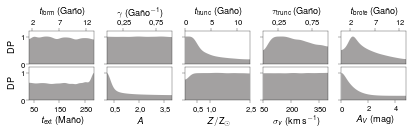

In [5]:
kws = "tform", "gamma", "tcut", "taucut", "burstage", "burstext", "A", "Z", "sigma", ("tau", "mu")
lbs = r"$t_\text{form}$ (Ga\~no)", r"$\gamma$ (Ga\~no$^{-1}$)", r"$t_\text{trunc}$ (Ga\~no)", r"$\tau_\text{trunc}$ (Ga\~no)", r"$t_\text{brote}$ (Ga\~no)", r"$t_\text{ext}$ (Ma\~no)", r"$A$", r"$Z/\text{Z}_\odot$", r"$\sigma_v$ (km\,s$^{-1}$)", r"$A_V$ (mag)"
fns = lambda t,x: t[x], lambda t,x: t[x], lambda t,x: t[x], lambda t,x: t[x], lambda t,x: t[x], lambda t,x: t[x], lambda t,x: t[x], lambda t,x: t[x], lambda t,x: t[x], lambda t,x: 1.086*t[x[0]]*t[x[1]]
uns = 1e-9, 1e9, 1e-9, 1e-9, 1e-9, 1e-6, 1, 1, 1, 1
tks = (2,7,12), (0.25,0.75), (0,5,10), (0.25,0.75), (2,7,12), (50,150,250), (0.5,2.0,3.5), (0.5,1,2.5), (50,200,350), (0,2,4)
nb = 100

fig, axs = subplots(2, len(kws)/2, figsize=(6,2), sharey=True)

ylim(0,1.2)

axs = axs.ravel()

for j in xrange(axs.size):
    par = fns[j](recipe, kws[j])
    mask = ~isnan(par)
    
    N, xe = histogram(par[mask], nb)
    x = 0.5*(xe[1:]+xe[:-1]) * uns[j]
    
    X = linspace(x.min(), x.max(), 100)
    Y = gaussian_filter(interp(X, x, N),5)
    
    #axs[j].fill_between(X, Y/Y.max(), facecolor="none", edgecolor=samples["medium"], lw=0, hatch=10*"/")
    axs[j].fill_between(X, (Y/Y.max()+0.2)/1.2, facecolor=samples["medium"], lw=0)
    axs[j].set_xlim(X.min(), X.max())
    axs[j].set_xticks(tks[j])
    axs[j].set_xlabel(lbs[j])
    if axs[j].is_first_col(): axs[j].set_ylabel(r"DP")
    if axs[j].is_first_row():
        axs[j].tick_params(bottom=False, labelbottom=False, top=True, labeltop=True)
        axs[j].xaxis.set_label_position("top")

fig.tight_layout()
fig.subplots_adjust(wspace=0.2, hspace=0.1)
fig.savefig("{}/ssag-pdf".format(os.path.expandvars("$HOME/Documents/Publications/PhD-thesis/figures")))

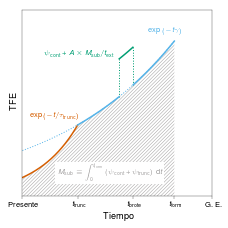

In [16]:
fig, ax = subplots(1, 1)

psi_cont = lambda t, gamma, tform, mask: exp(-(tform-t)*gamma)*mask.astype(float)
psi_trun = lambda t, ttrun, tautrun, cont, mask: cont*exp(-(ttrun-t)/tautrun)*mask.astype(float)
psi_burs = lambda t, tburs, text, A, mass, mask: mass*A/text*ones(t.size)*mask.astype(float)

t = linspace(0.0, 13.75e9, 1000)

tform = 11e9
gamma = 1/9e9
ttrun = 4e9
tautrun = 3e9
tburs = 8e9
text = 1e9
A = 0.05

mask_trun = t<=ttrun
mask_burs = (t<=tburs)&(t>=tburs-text)
mask_cont = (t<=tform)&(~mask_trun)

psi_tot = psi_cont(t, gamma, tform, mask_cont&(~mask_trun)) +\
          psi_trun(t, ttrun, tautrun, interp(ttrun,t,psi_cont(t,gamma,tform,ones(t.size))), mask_trun)

xlim(t[0], t[-1])
ylim(0.0,1.2)

fill_between(t[mask_cont|mask_trun], psi_tot[mask_cont|mask_trun], lw=0, facecolor="none", edgecolor=samples["medium"], hatch=7*"/")
plot(t[mask_trun], psi_trun(t,ttrun,tautrun,interp(ttrun,t,psi_cont(t,gamma,tform,ones(t.size))),mask_trun)[mask_trun], lw=1.5, color=samples["hot"])
plot(t[mask_burs], psi_burs(t,tburs,text,A,trapz(psi_cont(t,gamma,tform,mask_cont),t),mask_burs)[mask_burs]+psi_cont(t,gamma,tform,mask_burs)[mask_burs], lw=1.5, color=samples["warm"])
axvline(tburs-text, psi_cont(t,gamma,tform,mask_cont)[mask_burs].min()/1.2, (psi_burs(t,tburs,text,A,trapz(psi_cont(t,gamma,tform,mask_cont),t),mask_burs)[mask_burs]+psi_cont(t,gamma,tform,mask_burs)[mask_burs]).min()/1.2, ls=":", lw=1.0, color=samples["warm"])
axvline(tburs, psi_cont(t,gamma,tform,mask_cont)[mask_burs].max()/1.2, (psi_burs(t,tburs,text,A,trapz(psi_cont(t,gamma,tform,mask_cont),t),mask_burs)[mask_burs]+psi_cont(t,gamma,tform,mask_burs)[mask_burs]).max()/1.2, ls=":", lw=1.0, color=samples["warm"])
plot(t[mask_cont&(t<tburs-text)], psi_cont(t,gamma,tform,mask_cont)[mask_cont&(t<tburs-text)], lw=1.5, color=samples["cold"])
plot(t[mask_cont&(t>tburs)], psi_cont(t,gamma,tform,mask_cont)[mask_cont&(t>tburs)], lw=1.5, color=samples["cold"])
plot(t[mask_cont|(mask_trun)], psi_cont(t,gamma,tform,mask_cont|(mask_trun))[mask_cont|(mask_trun)], ":", lw=1.0, color=samples["cold"])

gca().set_yticks([])
gca().set_xticks([t[0],ttrun,tburs,tform,t[-1]])
gca().set_xticklabels(r"Presente,$t_\text{trunc}$,$t_\text{brote}$,$t_\text{form}$,G.~E.".split(","))

xlabel(r"Tiempo")
ylabel(r"TFE")

plt.text(0.05e10, 0.50, r"$$\exp{\left(-t/\tau_\text{trunc}\right)}$$", size=tsize, color=samples["hot"], ha="left")
plt.text(0.90e10, 1.05, r"$$\exp{\left(-t\gamma\right)}$$", color=samples["cold"], size=tsize, ha="left")
plt.text(0.15e10, 0.90, r"$$\psi_\text{cont}+A\times M_\text{sub}/t_\text{ext}$$", color=samples["warm"], size=tsize, ha="left")
plt.text(0.25e10, 0.10, r"$$M_\text{sub}\equiv\int_{0}^{t_{\text{form}}}\left(\psi_\text{cont}+\psi_\text{trunc}\right)\,\text{d}t\,$$", size=tsize, ha="left", color=samples["medium"], bbox=dict(fc="w", ec="none",pad=2))

tight_layout()
savefig("{}/ssag-sfh".format(os.path.expandvars("$HOME/Documents/Publications/PhD-thesis/figures")))